#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

#### Загрузка библиотек

In [29]:
!pip install --user xgboost

In [68]:
!pip install sweetviz -q
!pip install optuna 
import sweetviz as sv

     |████████████████████████████████| 308 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 49 kB 6.6 MB/s  eta 0:00:01
     |████████████████████████████████| 146 kB 54.2 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 38.6 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=ca5aaefd7857709902e81e17f488a3abf20211b39f459e5d4bf6fca2ab31c531
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


In [37]:
import time
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoost, CatBoostRegressor, Pool
import lightgbm  as lgb
from lightgbm import LGBMRegressor

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Загрузка данных

In [86]:
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df_taxi = pd.read_csv('F:/taxi.csv', index_col=[0], parse_dates=[0])

In [40]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверка правильной хронологической последовательности временного ряда

In [41]:
df_taxi.index.is_monotonic

True

Ресемплинг по 1 часу

In [91]:
df_taxi_1d = df_taxi.resample('1D').sum()
df_taxi = df_taxi.resample('1H').sum()
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

<Figure size 1080x360 with 0 Axes>

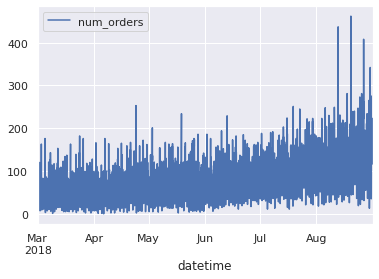

In [92]:
sns.set()
plt.figure(figsize=(15, 5))
df_taxi.plot()

## Анализ

                                             |          | [  0%]   00:00 -> (? left)


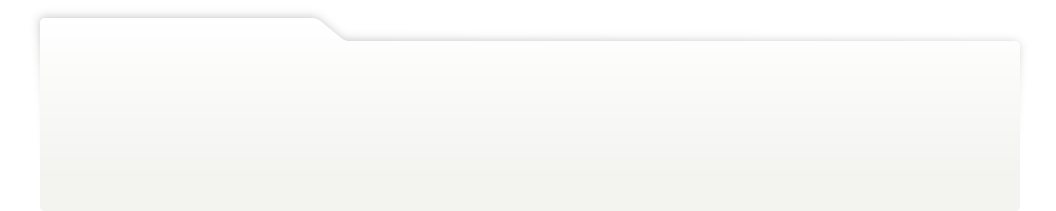
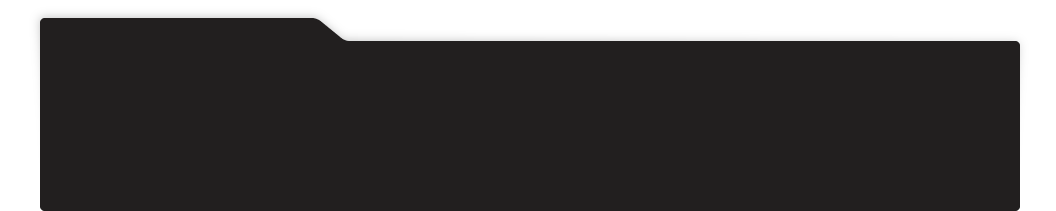
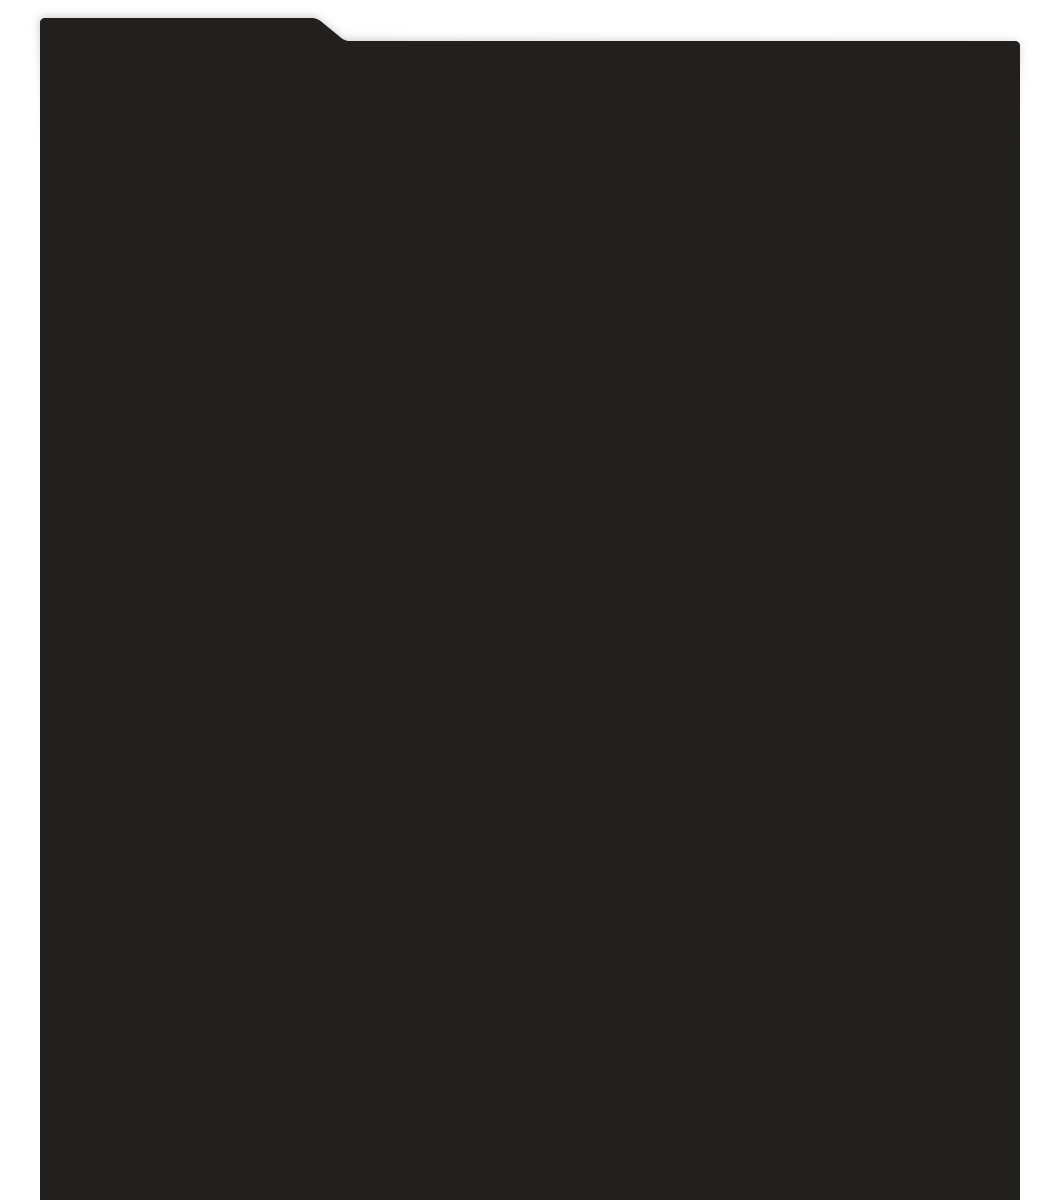
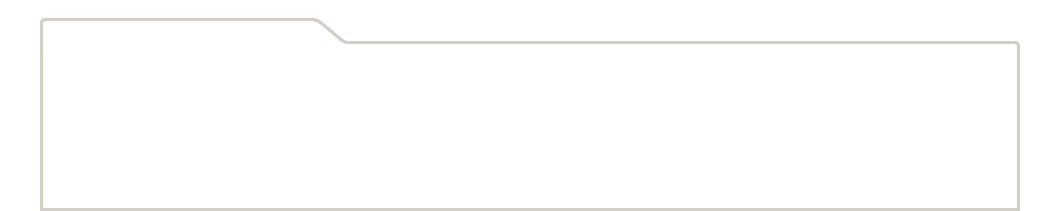
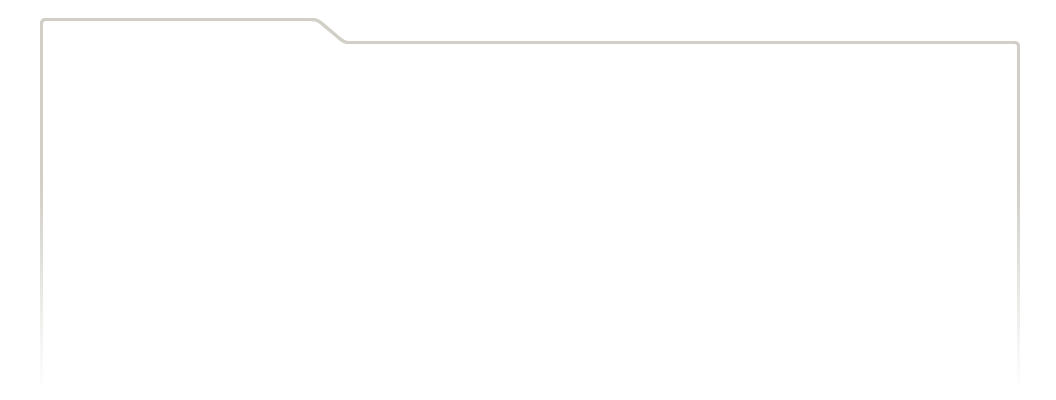
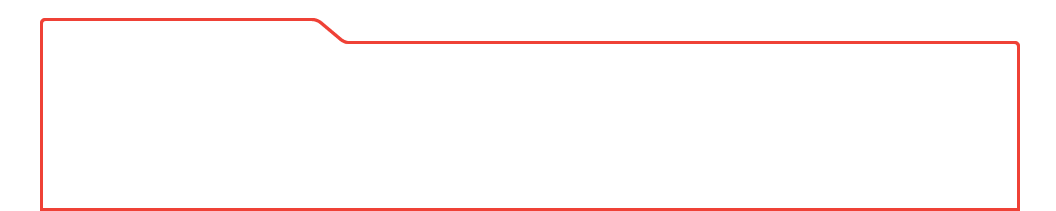
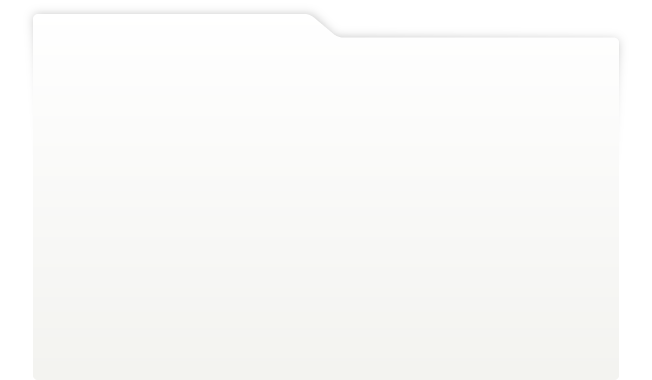
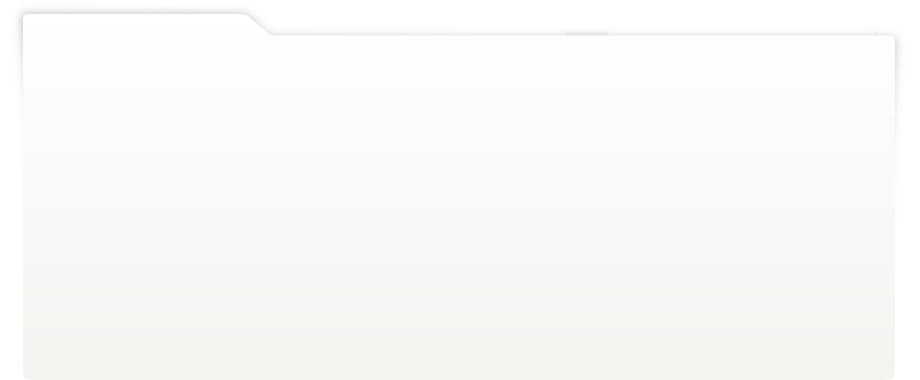
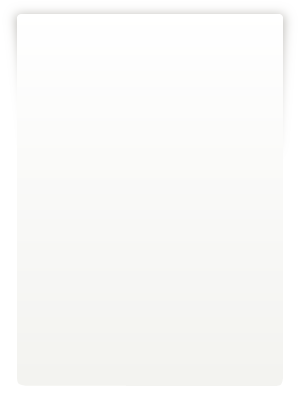
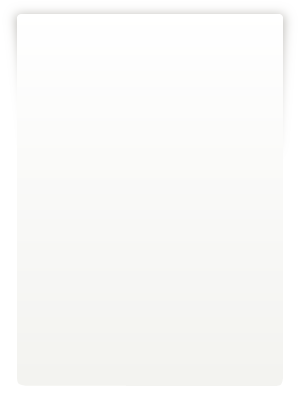
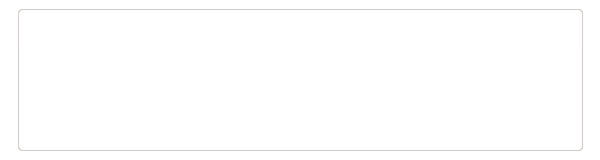
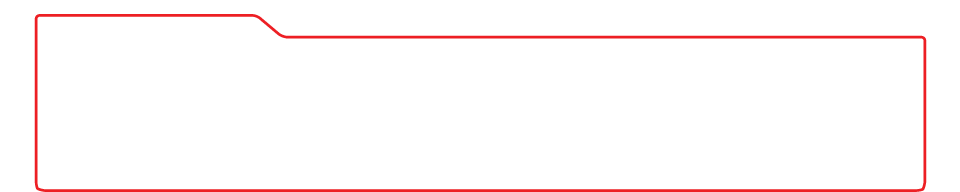
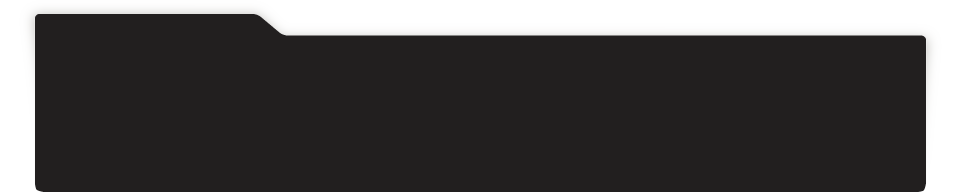
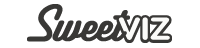
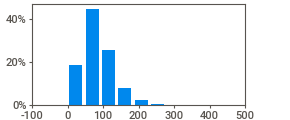
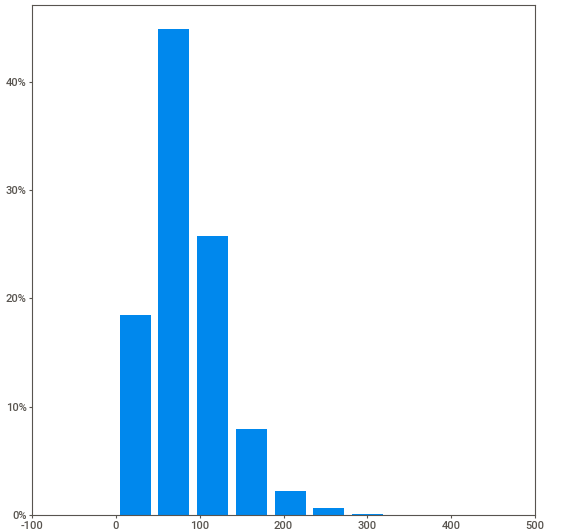
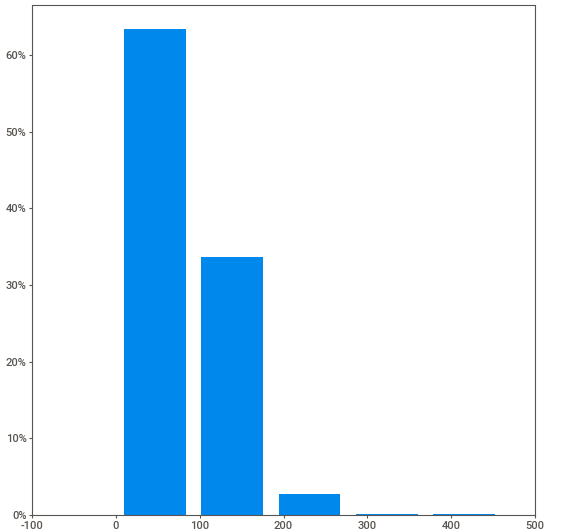
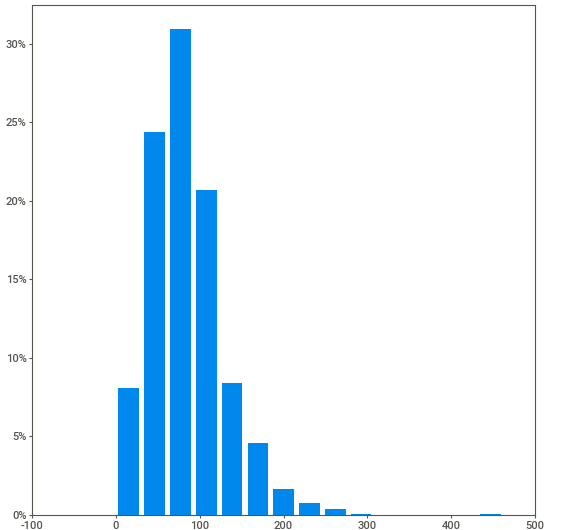
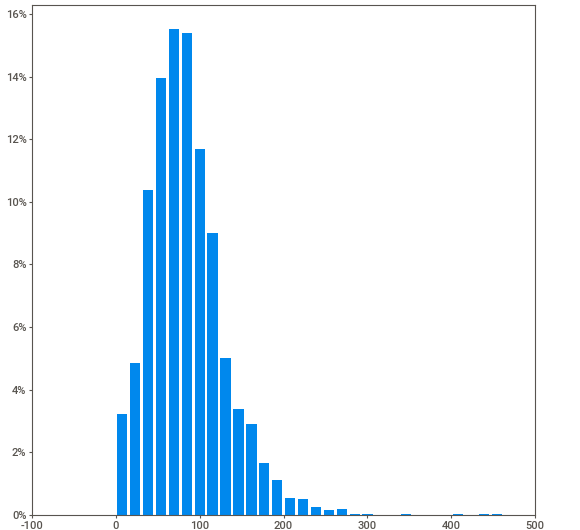

In [9]:
report_df_taxi = sv.analyze([df_taxi, 'Заказы такси'], pairwise_analysis='off')
report_df_taxi.show_notebook(w='100%', h='full', scale=None, filepath=None)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
C твоего позволения - не буду запускать это модль - ресурсов может занять много.... Но понимаю, что сейчас увижу, ОК.

Временной ряд со скользящим средним в 24 часа

<AxesSubplot:xlabel='datetime'>

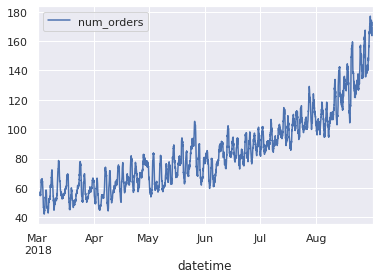

In [44]:
sns.set()
df_taxi.rolling(24).mean().plot()

Разложение временного ряда на тренд, сезонность и остаток

In [45]:
decomposed = seasonal_decompose(df_taxi.rolling(24*14).mean().dropna())

Тренд за все время

<AxesSubplot:xlabel='datetime'>

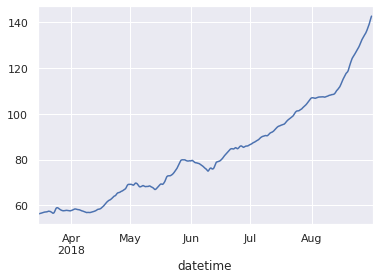

In [46]:
decomposed.trend.plot()

Тренд за апрель 2018

<AxesSubplot:xlabel='datetime'>

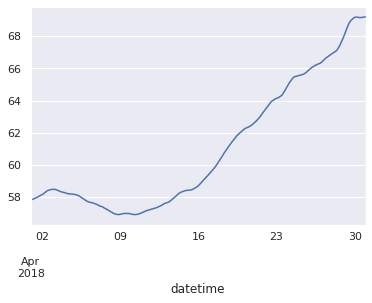

In [47]:
decomposed.trend['2018-04':'2018-04'].plot()

Дневная сезонность за апрель 2018

<AxesSubplot:xlabel='datetime'>

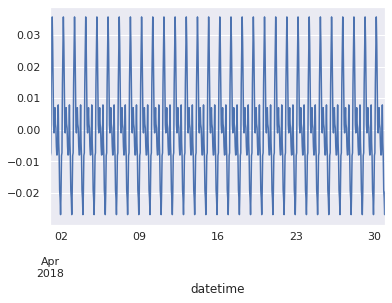

In [48]:
decomposed.seasonal['2018-04':'2018-04'].plot()

Внунтридневная сезонность

<AxesSubplot:xlabel='datetime'>

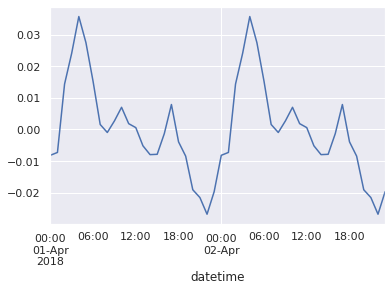

In [49]:
decomposed.seasonal['2018-04-01':'2018-04-02'].plot()

Остатки (шумы) за все время

<AxesSubplot:xlabel='datetime'>

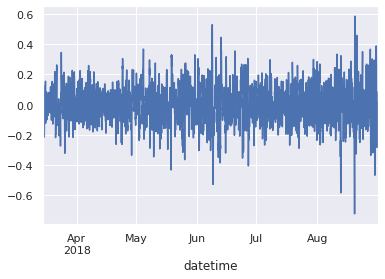

In [50]:
decomposed.resid.plot()

Остатки (шумы) за апрель 2018

<AxesSubplot:xlabel='datetime'>

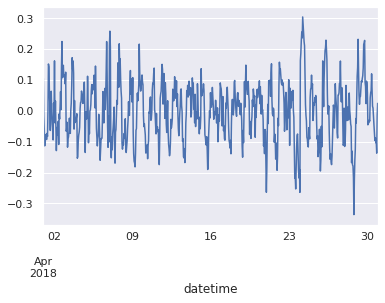

In [51]:
decomposed.resid['2018-04':'2018-04'].plot()

In [52]:
df_taxi_1d.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [53]:
decomposed_1d = seasonal_decompose(df_taxi.rolling(7).mean().dropna())

<AxesSubplot:xlabel='datetime'>

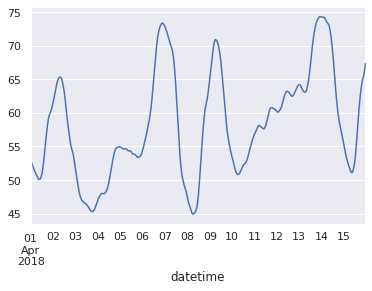

In [54]:
decomposed_1d.trend['2018-04-01':'2018-04-15'].plot()

#### Выводы

Видим, что с марта по август 2018 года исходя из кривой тренда срднее число заказов в час неуклонно растет с примерно 60 до 140. Из-за осутсвия данных мы не можем сказать, этот тренд связан с общим успехом бизнеса или с месячной сезонностью. Наблюдается дневная сезонность, связанная с пользовательской активностью в часы пик и ночное время, когда не работает общественный транспорт, а также недельная сезонность. На всем рассматриваемом временном отрезке волатильность числа заказов возрастает.

## Обучение

#### Фичеинжиниринг

Добавим в датасет вспомогательные признаки

Функция возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature

In [55]:
def code_mean(data, cat_feature, real_feature):
    
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [56]:
def prepare_data(data, lag_start=1, lag_end=13, test_size=0.1, rolling_mean_size=13):

    data = pd.DataFrame(data.copy())
    data.columns = ['num_orders']
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем временные признаки из datetime индекса
    # data['month'] = data.index.month
    # data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # добавляем лаги исходного ряда в качестве признаков
    for lag in range(lag_start, lag_end):
        data['lag_%s' % lag] = data['num_orders'].shift(lag)
        
    # добавляем признак скользящего среднего, не включая текущее значение
    data['rolling_mean'] = data['num_orders'].rolling(window=rolling_mean_size, closed='left').mean()

    # считаем средние только по тренировочной части, чтобы избежать лика
    # data['month_average'] = list(map(code_mean(data[:test_index], 'month', 'num_orders').get, data['month']))
    # data['day_average'] = list(map(code_mean(data[:test_index], 'day', 'num_orders').get, data['day']))
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'num_orders').get, data['weekday']))
    data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'num_orders').get, data['hour']))

    # выкидываем закодированные средними признаки 
    data.drop(['hour', 'weekday'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборки
    X_train = data.loc[:test_index].drop(['num_orders'], axis=1)
    y_train = data.loc[:test_index]['num_orders']
    X_test = data.loc[test_index:].drop(['num_orders'], axis=1)
    y_test = data.loc[test_index:]['num_orders']

    return X_train, X_test, y_train, y_test

In [57]:
X_train, X_test, y_train, y_test = prepare_data(df_taxi)
X_train.head()

,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean,weekday_average,hour_average
0,0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.000000,78.276042,67.343373
1,0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.923077,78.276042,69.945455
2,0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,45.076923,78.276042,81.672727
3,0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,44.692308,78.276042,107.321212
4,0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,42.923077,78.276042,82.836364


Процедура кроссвалидации временного ряда

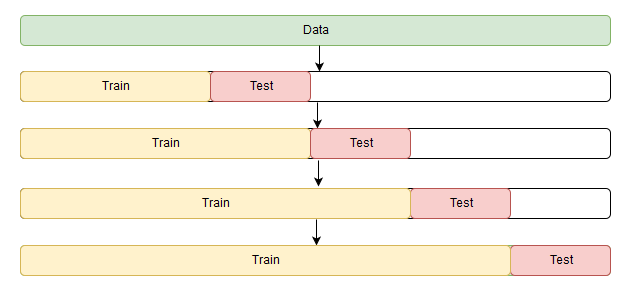

In [58]:
def time_series_cv(X_train, y_train, number_folds, model):
    
    print(f'Размер обучающей выборки: {X_train.shape}')

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print(f'Размер фолда: {k}')

    score = np.zeros(number_folds-1)

    # Цикл от 2 до максимального количества фолдов
    for i in range(2, number_folds + 1):

        split = float(i-1)/i
        print('Разбиение первых ' + str(i) + ' фолдов в соотношении ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print(f'Размер обучающей + тестовой выборок: {X.shape}') # размер выборки должен быть k*i

        idx = int(np.floor(X.shape[0] * split))

        # фолды для обучения        
        X_trainFolds = X[:idx]        
        y_trainFolds = y[:idx]

        # фолды для тестирования
        X_testFold = X[(idx + 1):]
        y_testFold = y[(idx + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        score[i-2] = mean_squared_error(model.predict(X_testFold), y_testFold, squared=False)

    # функция возвращает среднюю метрику потерь на n-1 фолде
    return score.mean()

Тестирование процедуры

In [59]:
%%time

time_series_cv(X_train, y_train, 5, LinearRegression())

Размер обучающей выборки: (3975, 16)
Размер фолда: 795
Разбиение первых 2 фолдов в соотношении 1/2
Размер обучающей + тестовой выборок: (1590, 16)
Разбиение первых 3 фолдов в соотношении 2/3
Размер обучающей + тестовой выборок: (2385, 16)
Разбиение первых 4 фолдов в соотношении 3/4
Размер обучающей + тестовой выборок: (3180, 16)
Разбиение первых 5 фолдов в соотношении 4/5
Размер обучающей + тестовой выборок: (3975, 16)
CPU times: user 173 ms, sys: 251 ms, total: 423 ms
Wall time: 387 ms


26.758252320315545

Подбор алгоритма модели под задачу и данные

In [60]:
state = RandomState(12345)

In [62]:
%%time

models = [DecisionTreeRegressor(random_state=state), 
          RandomForestRegressor(random_state=state),
          LinearRegression(),
          KNeighborsRegressor(),
          Ridge(),
          CatBoostRegressor(verbose=False)]

results_cross_val = []

for model in models: 
    start_time = time.time()
    cv_score = time_series_cv(X_train, y_train, 5, model)    
    elapsed_time = time.time() - start_time
    results_cross_val.append({'model_name': model.__class__.__name__, 
                              'cv_score': '%.2f' % cv_score,
                              'learn_time': '%.2f' % elapsed_time}) 

Размер обучающей выборки: (3975, 16)
Размер фолда: 795
Разбиение первых 2 фолдов в соотношении 1/2
Размер обучающей + тестовой выборок: (1590, 16)
Разбиение первых 3 фолдов в соотношении 2/3
Размер обучающей + тестовой выборок: (2385, 16)
Разбиение первых 4 фолдов в соотношении 3/4
Размер обучающей + тестовой выборок: (3180, 16)
Разбиение первых 5 фолдов в соотношении 4/5
Размер обучающей + тестовой выборок: (3975, 16)
Размер обучающей выборки: (3975, 16)
Размер фолда: 795
Разбиение первых 2 фолдов в соотношении 1/2
Размер обучающей + тестовой выборок: (1590, 16)
Разбиение первых 3 фолдов в соотношении 2/3
Размер обучающей + тестовой выборок: (2385, 16)
Разбиение первых 4 фолдов в соотношении 3/4
Размер обучающей + тестовой выборок: (3180, 16)
Разбиение первых 5 фолдов в соотношении 4/5
Размер обучающей + тестовой выборок: (3975, 16)
Размер обучающей выборки: (3975, 16)
Размер фолда: 795
Разбиение первых 2 фолдов в соотношении 1/2
Размер обучающей + тестовой выборок: (1590, 16)
Разбиен

In [63]:
pd.DataFrame(results_cross_val).sort_values('cv_score')

,model_name,cv_score,learn_time
1,RandomForestRegressor,24.89,7.52
5,CatBoostRegressor,25.43,18.11
2,LinearRegression,26.76,0.30
4,Ridge,26.76,0.26
3,KNeighborsRegressor,28.41,0.93
0,DecisionTreeRegressor,34.32,0.14


Подбор гиперпараметров для Ridge с помощью GridSearchCV из sklearn

Кроссвалидацию временного ряда можно задать через встроенный в sklearn метод

In [64]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
#    gap=48,
#    max_train_size=10000,
#    test_size=1000,
)
rmse = 'neg_root_mean_squared_error'

In [65]:
%%time

pipe = Pipeline([
    ('model', Ridge(random_state=state))
])

params = [
    {
        'model': [Ridge(random_state=state)],
        'model__alpha': [1000, 100, 10, 1, 0.1],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
    }
]

search = GridSearchCV(pipe, param_grid=params, cv=ts_cv, n_jobs=-1, scoring=rmse)
search.fit(X_train, y_train)

print('Best Params:', search.best_params_)
print('Best Score:', search.best_score_)

Best Params: {'model': Ridge(alpha=1000, random_state=RandomState(MT19937) at 0x7FC63CDDFD40), 'model__alpha': 1000, 'model__solver': 'auto'}
Best Score: -26.182731078382083
CPU times: user 24.3 s, sys: 13.6 s, total: 37.9 s
Wall time: 37.9 s


Подбор гиперпараметров для Random Forest с помощью HalvingRandomSearchCV из sklearn

In [29]:
%%time

pipe = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'model': [RandomForestRegressor(random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10),
        'model__n_estimators': np.arange(10, 111, 20),
    }
]

search = HalvingRandomSearchCV(pipe, param_distributions=params, cv=ts_cv, n_jobs=-1, scoring=rmse, verbose=1)
search.fit(X_train, y_train)

print('\nBest Params:', search.best_params_)
print('Best Score:', search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 10
max_resources_: 3975
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 10
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 20
n_resources: 30
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 7
n_resources: 90
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 270
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Params: {'model__n_estimators': 50, 'model__max_features': 0.9, 'model': RandomForestRegressor(max_features=0.9, n_estimators=50,
                      random_state=RandomState(MT19937) at 0x7FCA45E24040)}
Best Score: -28.03881433839727
CPU times: user 28.8 s, sys: 0 ns, total: 28.8 s
Wall time: 29 s


Подбор гиперпараметров для Random Forest с помощью GridSearchCV из sklearn

In [66]:
%%time

pipe = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'model': [RandomForestRegressor(random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10),
        'model__n_estimators': np.arange(10, 111, 20),
    }
]

search = GridSearchCV(pipe, param_grid=params, cv=ts_cv, n_jobs=-1, scoring=rmse)
search.fit(X_train, y_train)

print('Best Params:', search.best_params_)
print('Best Score:', search.best_score_)

Best Params: {'model': RandomForestRegressor(max_features=0.6, n_estimators=90,
                      random_state=RandomState(MT19937) at 0x7FC63CDDFD40), 'model__max_features': 0.6, 'model__n_estimators': 90}
Best Score: -24.499958782420258
CPU times: user 3min 19s, sys: 0 ns, total: 3min 19s
Wall time: 3min 21s


Подбор гиперпараметров для CatBoost с помощью Optuna

In [69]:
%%time

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

import optuna

def objective(trial):

    optuna_params = {'subsample': trial.suggest_float('subsample', 0.5, 0.99),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.99),
                     'random_strength': trial.suggest_int('random_strength', 1, 10, step=1),
                     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 50.0),
                     'max_depth': trial.suggest_int('max_depth', 4, 10, step=1),
                     'n_estimators': trial.suggest_int('n_estimators', 100, 2500, step=1),
                     'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1)}

    cbregressor = CatBoostRegressor(**optuna_params, 
                                       random_state=0,
                                       loss_function='RMSE', 
                                       eval_metric='RMSE', 
                                       one_hot_max_size=0,
                                       boost_from_average=True)
    
    cat_optuna = cbregressor.fit(train_pool, eval_set=test_pool, verbose=False, early_stopping_rounds=10)
    
    y_test_pred = cat_optuna.predict(X_test)
    
    RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
    print('RMSE score of CatBoost =', RMSE)
    return RMSE

study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler(seed=0), study_name='Catboost Optuna')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2022-05-07 22:06:46,757] A new study created in memory with name: Catboost Optuna
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-05-07 22:07:17,988] Trial 1 finished with value: 45.05476975688407 and parameters: {'subsample': 0.910754356544828, 'od_wait': 48, 'colsample_bylevel': 0.7969676578693141, 'random_strength': 9, 'l2_leaf_reg': 44.16339258176538, 

RMSE score of CatBoost = 45.05476975688407


[I 2022-05-07 22:07:30,581] Trial 3 finished with value: 46.695842787154 and parameters: {'subsample': 0.8607046990447375, 'od_wait': 30, 'colsample_bylevel': 0.8949721746392123, 'random_strength': 2, 'l2_leaf_reg': 21.087916824176766, 'max_depth': 7, 'n_estimators': 471, 'learning_rate': 0.024530964169407872}. Best is trial 1 with value: 45.05476975688407.


RMSE score of CatBoost = 46.695842787154


[I 2022-05-07 22:07:34,485] Trial 4 finished with value: 45.84075002419695 and parameters: {'subsample': 0.5706066329932937, 'od_wait': 32, 'colsample_bylevel': 0.7254480232898839, 'random_strength': 7, 'l2_leaf_reg': 13.746616300102634, 'max_depth': 5, 'n_estimators': 1227, 'learning_rate': 0.00885724070915584}. Best is trial 1 with value: 45.05476975688407.


RMSE score of CatBoost = 45.84075002419695


[I 2022-05-07 22:07:46,685] Trial 10 finished with value: 43.056100962811904 and parameters: {'subsample': 0.9254657778824376, 'od_wait': 22, 'colsample_bylevel': 0.7126683207802333, 'random_strength': 7, 'l2_leaf_reg': 18.83900646458831, 'max_depth': 5, 'n_estimators': 2399, 'learning_rate': 0.08587676314366346}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 43.056100962811904


[I 2022-05-07 22:08:47,587] Trial 11 finished with value: 43.54837496602402 and parameters: {'subsample': 0.5920134655437189, 'od_wait': 10, 'colsample_bylevel': 0.8210987371751455, 'random_strength': 9, 'l2_leaf_reg': 33.39375302686201, 'max_depth': 5, 'n_estimators': 1619, 'learning_rate': 0.018624873998108974}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 43.54837496602402


[I 2022-05-07 22:09:58,189] Trial 9 finished with value: 45.35452759756134 and parameters: {'subsample': 0.9615571416935935, 'od_wait': 48, 'colsample_bylevel': 0.630384621304237, 'random_strength': 3, 'l2_leaf_reg': 31.025113090305624, 'max_depth': 9, 'n_estimators': 2263, 'learning_rate': 0.0976122816076046}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 45.35452759756134


[I 2022-05-07 22:10:09,187] Trial 13 finished with value: 43.93181935406531 and parameters: {'subsample': 0.8810903336485998, 'od_wait': 29, 'colsample_bylevel': 0.8501984992993419, 'random_strength': 7, 'l2_leaf_reg': 24.800319209618994, 'max_depth': 4, 'n_estimators': 1053, 'learning_rate': 0.07525811494138976}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 43.93181935406531


[I 2022-05-07 22:10:15,292] Trial 12 finished with value: 48.23929229837291 and parameters: {'subsample': 0.731159826659675, 'od_wait': 14, 'colsample_bylevel': 0.9119287363724857, 'random_strength': 2, 'l2_leaf_reg': 36.632122911783554, 'max_depth': 7, 'n_estimators': 990, 'learning_rate': 0.01492782084140079}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 48.23929229837291


[I 2022-05-07 22:10:39,783] Trial 6 finished with value: 43.804650746156895 and parameters: {'subsample': 0.9591094390755168, 'od_wait': 37, 'colsample_bylevel': 0.5594890791930077, 'random_strength': 2, 'l2_leaf_reg': 6.992579462448136, 'max_depth': 9, 'n_estimators': 1590, 'learning_rate': 0.03754092798585864}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 43.804650746156895


[I 2022-05-07 22:10:50,492] Trial 15 finished with value: 44.61882574378931 and parameters: {'subsample': 0.8474878459139505, 'od_wait': 15, 'colsample_bylevel': 0.7992532768701619, 'random_strength': 6, 'l2_leaf_reg': 42.21766269819046, 'max_depth': 6, 'n_estimators': 2393, 'learning_rate': 0.055252775595441325}. Best is trial 10 with value: 43.056100962811904.


RMSE score of CatBoost = 44.61882574378931


[I 2022-05-07 22:10:51,588] Trial 16 finished with value: 42.42139806435101 and parameters: {'subsample': 0.6860537570134022, 'od_wait': 47, 'colsample_bylevel': 0.7234764052958635, 'random_strength': 10, 'l2_leaf_reg': 9.732138902537107, 'max_depth': 5, 'n_estimators': 1241, 'learning_rate': 0.09083335230493926}. Best is trial 16 with value: 42.42139806435101.


RMSE score of CatBoost = 42.42139806435101


[I 2022-05-07 22:10:54,089] Trial 5 finished with value: 45.70443840838095 and parameters: {'subsample': 0.5724431142200298, 'od_wait': 44, 'colsample_bylevel': 0.6603248288206511, 'random_strength': 7, 'l2_leaf_reg': 41.04152528798959, 'max_depth': 9, 'n_estimators': 968, 'learning_rate': 0.0772872875521776}. Best is trial 16 with value: 42.42139806435101.


RMSE score of CatBoost = 45.70443840838095


[I 2022-05-07 22:10:59,895] Trial 14 finished with value: 44.16490709606365 and parameters: {'subsample': 0.7855289690857785, 'od_wait': 46, 'colsample_bylevel': 0.6513605409649297, 'random_strength': 2, 'l2_leaf_reg': 41.879543487374235, 'max_depth': 7, 'n_estimators': 2119, 'learning_rate': 0.08248008851264471}. Best is trial 16 with value: 42.42139806435101.


RMSE score of CatBoost = 44.16490709606365


[I 2022-05-07 22:11:01,786] Trial 18 finished with value: 40.361207397120715 and parameters: {'subsample': 0.707158870145693, 'od_wait': 24, 'colsample_bylevel': 0.6922211421127907, 'random_strength': 10, 'l2_leaf_reg': 3.456610843781876, 'max_depth': 4, 'n_estimators': 1936, 'learning_rate': 0.09205978149179381}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 40.361207397120715


[I 2022-05-07 22:11:06,785] Trial 19 finished with value: 42.20630356712625 and parameters: {'subsample': 0.701046560028363, 'od_wait': 23, 'colsample_bylevel': 0.706199954684723, 'random_strength': 10, 'l2_leaf_reg': 3.9731321960651265, 'max_depth': 4, 'n_estimators': 1880, 'learning_rate': 0.04884922708138825}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.20630356712625


[I 2022-05-07 22:11:13,789] Trial 20 finished with value: 41.06270819350384 and parameters: {'subsample': 0.6932333767396525, 'od_wait': 22, 'colsample_bylevel': 0.7321862115299214, 'random_strength': 10, 'l2_leaf_reg': 1.6000682671155904, 'max_depth': 4, 'n_estimators': 1795, 'learning_rate': 0.05168776277762568}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 41.06270819350384


[I 2022-05-07 22:11:19,789] Trial 22 finished with value: 40.718305677189896 and parameters: {'subsample': 0.6686982260403128, 'od_wait': 23, 'colsample_bylevel': 0.5215401045404384, 'random_strength': 10, 'l2_leaf_reg': 2.1833720496746274, 'max_depth': 4, 'n_estimators': 1877, 'learning_rate': 0.04829909821659051}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 40.718305677189896


[I 2022-05-07 22:11:52,282] Trial 21 finished with value: 43.64396996131906 and parameters: {'subsample': 0.6750533750045116, 'od_wait': 24, 'colsample_bylevel': 0.5758537522931481, 'random_strength': 10, 'l2_leaf_reg': 1.6061606309648493, 'max_depth': 4, 'n_estimators': 1850, 'learning_rate': 0.0058915915203415796}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 43.64396996131906


[I 2022-05-07 22:12:17,094] Trial 23 finished with value: 43.48219061285782 and parameters: {'subsample': 0.6620751928083606, 'od_wait': 23, 'colsample_bylevel': 0.9883673606808149, 'random_strength': 4, 'l2_leaf_reg': 3.556144232250745, 'max_depth': 4, 'n_estimators': 1801, 'learning_rate': 0.005203669750046131}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 43.48219061285782


[I 2022-05-07 22:12:19,892] Trial 25 finished with value: 43.28950477076166 and parameters: {'subsample': 0.6418437337891847, 'od_wait': 38, 'colsample_bylevel': 0.5179511603467157, 'random_strength': 4, 'l2_leaf_reg': 11.397722412602631, 'max_depth': 6, 'n_estimators': 2116, 'learning_rate': 0.027051061453864184}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 43.28950477076166


[I 2022-05-07 22:12:47,385] Trial 24 finished with value: 45.727154237814965 and parameters: {'subsample': 0.6314958475629332, 'od_wait': 25, 'colsample_bylevel': 0.525315822874637, 'random_strength': 5, 'l2_leaf_reg': 12.888364918771874, 'max_depth': 6, 'n_estimators': 2036, 'learning_rate': 0.005221753646280149}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 45.727154237814965


[I 2022-05-07 22:13:00,781] Trial 28 finished with value: 42.57266652323007 and parameters: {'subsample': 0.7821336810856936, 'od_wait': 19, 'colsample_bylevel': 0.6117901288234361, 'random_strength': 9, 'l2_leaf_reg': 7.109632943128704, 'max_depth': 4, 'n_estimators': 1520, 'learning_rate': 0.05656453472438227}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.57266652323007


[I 2022-05-07 22:14:31,990] Trial 2 finished with value: 49.11955175670093 and parameters: {'subsample': 0.8373353853817533, 'od_wait': 10, 'colsample_bylevel': 0.7810626214203839, 'random_strength': 7, 'l2_leaf_reg': 36.06065944813803, 'max_depth': 10, 'n_estimators': 1268, 'learning_rate': 0.032379010423096904}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 49.11955175670093


[I 2022-05-07 22:14:43,986] Trial 30 finished with value: 42.71776199317652 and parameters: {'subsample': 0.7628870659314271, 'od_wait': 16, 'colsample_bylevel': 0.676286875112361, 'random_strength': 8, 'l2_leaf_reg': 16.707330830827466, 'max_depth': 4, 'n_estimators': 1748, 'learning_rate': 0.0643697972498997}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.71776199317652


[I 2022-05-07 22:14:53,789] Trial 31 finished with value: 48.0418407529234 and parameters: {'subsample': 0.5098325914630069, 'od_wait': 27, 'colsample_bylevel': 0.7625454629776179, 'random_strength': 9, 'l2_leaf_reg': 1.138712282536341, 'max_depth': 6, 'n_estimators': 116, 'learning_rate': 0.0448114765799222}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 48.0418407529234


[I 2022-05-07 22:16:18,896] Trial 32 finished with value: 42.574888475263194 and parameters: {'subsample': 0.730642282887003, 'od_wait': 19, 'colsample_bylevel': 0.5963335560402862, 'random_strength': 8, 'l2_leaf_reg': 7.44655757930065, 'max_depth': 8, 'n_estimators': 2018, 'learning_rate': 0.06442302883131693}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.574888475263194


[I 2022-05-07 22:16:52,192] Trial 27 finished with value: 46.54998640976548 and parameters: {'subsample': 0.5130942393175798, 'od_wait': 17, 'colsample_bylevel': 0.5055496397172747, 'random_strength': 8, 'l2_leaf_reg': 15.854462001051596, 'max_depth': 10, 'n_estimators': 1503, 'learning_rate': 0.03401623764549866}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 46.54998640976548


[I 2022-05-07 22:16:59,294] Trial 33 finished with value: 44.19581660852729 and parameters: {'subsample': 0.8050763373423704, 'od_wait': 34, 'colsample_bylevel': 0.6789996621179176, 'random_strength': 10, 'l2_leaf_reg': 49.327631323464054, 'max_depth': 5, 'n_estimators': 1440, 'learning_rate': 0.03220557455675467}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 44.19581660852729


[I 2022-05-07 22:17:08,888] Trial 35 finished with value: 43.07478156856182 and parameters: {'subsample': 0.707051940286966, 'od_wait': 27, 'colsample_bylevel': 0.5577423923606856, 'random_strength': 10, 'l2_leaf_reg': 6.187029453286403, 'max_depth': 4, 'n_estimators': 2253, 'learning_rate': 0.06568081265596158}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 43.07478156856182


[I 2022-05-07 22:17:16,186] Trial 0 finished with value: 53.76477145779147 and parameters: {'subsample': 0.7558516504644384, 'od_wait': 27, 'colsample_bylevel': 0.9860406171336389, 'random_strength': 6, 'l2_leaf_reg': 48.230823571180345, 'max_depth': 10, 'n_estimators': 1408, 'learning_rate': 0.012363045406453456}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 53.76477145779147


[I 2022-05-07 22:17:22,783] Trial 7 finished with value: 48.27992814301142 and parameters: {'subsample': 0.5668641620581832, 'od_wait': 14, 'colsample_bylevel': 0.5205899325107586, 'random_strength': 8, 'l2_leaf_reg': 37.297644925889564, 'max_depth': 10, 'n_estimators': 2497, 'learning_rate': 0.01231444759295232}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 48.27992814301142


[I 2022-05-07 22:17:27,093] Trial 34 finished with value: 42.2668309694506 and parameters: {'subsample': 0.6178319603015966, 'od_wait': 33, 'colsample_bylevel': 0.6807212908497129, 'random_strength': 10, 'l2_leaf_reg': 6.017743702354929, 'max_depth': 5, 'n_estimators': 1412, 'learning_rate': 0.019456168052344652}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.2668309694506


[I 2022-05-07 22:17:33,787] Trial 37 finished with value: 44.18737109484084 and parameters: {'subsample': 0.623361260239077, 'od_wait': 20, 'colsample_bylevel': 0.8874023044774302, 'random_strength': 9, 'l2_leaf_reg': 9.866998098963148, 'max_depth': 5, 'n_estimators': 1672, 'learning_rate': 0.048288576149837885}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 44.18737109484084


[I 2022-05-07 22:17:34,888] Trial 38 finished with value: 42.165815631796754 and parameters: {'subsample': 0.614160658227054, 'od_wait': 21, 'colsample_bylevel': 0.6965796642567991, 'random_strength': 10, 'l2_leaf_reg': 3.9810820056860265, 'max_depth': 4, 'n_estimators': 1890, 'learning_rate': 0.0492265473142703}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 42.165815631796754


[I 2022-05-07 22:17:36,693] Trial 36 finished with value: 43.37801208962007 and parameters: {'subsample': 0.6066195692056203, 'od_wait': 21, 'colsample_bylevel': 0.7572206358974404, 'random_strength': 9, 'l2_leaf_reg': 23.549664448508864, 'max_depth': 5, 'n_estimators': 1701, 'learning_rate': 0.04450568943893565}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 43.37801208962007


[I 2022-05-07 22:17:43,788] Trial 39 finished with value: 41.455254158724685 and parameters: {'subsample': 0.7046700793181644, 'od_wait': 20, 'colsample_bylevel': 0.7506982051900055, 'random_strength': 9, 'l2_leaf_reg': 3.756222736623259, 'max_depth': 4, 'n_estimators': 1881, 'learning_rate': 0.043282723522604316}. Best is trial 18 with value: 40.361207397120715.


RMSE score of CatBoost = 41.455254158724685


[I 2022-05-07 22:17:46,787] Trial 42 finished with value: 40.16058356743796 and parameters: {'subsample': 0.6494485619649556, 'od_wait': 26, 'colsample_bylevel': 0.6371995277100893, 'random_strength': 10, 'l2_leaf_reg': 1.0818386210250162, 'max_depth': 4, 'n_estimators': 1962, 'learning_rate': 0.058802804058509316}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.16058356743796


[I 2022-05-07 22:17:47,186] Trial 40 finished with value: 42.37201646754187 and parameters: {'subsample': 0.7044942555336305, 'od_wait': 21, 'colsample_bylevel': 0.7534774743281656, 'random_strength': 10, 'l2_leaf_reg': 3.8791227493255915, 'max_depth': 4, 'n_estimators': 1924, 'learning_rate': 0.04564003953592627}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.37201646754187


[I 2022-05-07 22:17:55,787] Trial 44 finished with value: 42.894227467216666 and parameters: {'subsample': 0.6597734024944418, 'od_wait': 26, 'colsample_bylevel': 0.635882176670004, 'random_strength': 1, 'l2_leaf_reg': 8.940203241314858, 'max_depth': 4, 'n_estimators': 2027, 'learning_rate': 0.0699502191247869}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.894227467216666


[I 2022-05-07 22:17:57,890] Trial 41 finished with value: 40.53919723410452 and parameters: {'subsample': 0.6627151093934164, 'od_wait': 25, 'colsample_bylevel': 0.7612651848664571, 'random_strength': 9, 'l2_leaf_reg': 3.4696008587400042, 'max_depth': 4, 'n_estimators': 1945, 'learning_rate': 0.038867166340210195}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.53919723410452


[I 2022-05-07 22:18:04,083] Trial 43 finished with value: 40.47248580803326 and parameters: {'subsample': 0.7232533948493515, 'od_wait': 27, 'colsample_bylevel': 0.823569587289924, 'random_strength': 9, 'l2_leaf_reg': 1.1190685241773002, 'max_depth': 4, 'n_estimators': 1955, 'learning_rate': 0.029985955472604266}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.47248580803326


[I 2022-05-07 22:18:38,696] Trial 48 finished with value: 44.79735185430309 and parameters: {'subsample': 0.7484668543191879, 'od_wait': 29, 'colsample_bylevel': 0.8394326056092214, 'random_strength': 8, 'l2_leaf_reg': 28.14681878846661, 'max_depth': 5, 'n_estimators': 2221, 'learning_rate': 0.029138980481519437}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 44.79735185430309


[I 2022-05-07 22:19:08,092] Trial 49 finished with value: 41.40934691800395 and parameters: {'subsample': 0.6577725349527833, 'od_wait': 30, 'colsample_bylevel': 0.9379629967209908, 'random_strength': 9, 'l2_leaf_reg': 5.480225803129349, 'max_depth': 5, 'n_estimators': 2148, 'learning_rate': 0.0354255862181464}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.40934691800395


[I 2022-05-07 22:19:31,791] Trial 50 finished with value: 40.559914257286685 and parameters: {'subsample': 0.551083663932861, 'od_wait': 36, 'colsample_bylevel': 0.7841970754206509, 'random_strength': 9, 'l2_leaf_reg': 1.5066050425173088, 'max_depth': 4, 'n_estimators': 755, 'learning_rate': 0.022783541654594477}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.559914257286685


[I 2022-05-07 22:19:37,886] Trial 26 finished with value: 45.850039920544916 and parameters: {'subsample': 0.7875519111814756, 'od_wait': 37, 'colsample_bylevel': 0.6025247598403108, 'random_strength': 8, 'l2_leaf_reg': 13.041575479809914, 'max_depth': 10, 'n_estimators': 2088, 'learning_rate': 0.029593338655352693}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 45.850039920544916


[I 2022-05-07 22:19:42,191] Trial 46 finished with value: 47.7541029191471 and parameters: {'subsample': 0.7584975461758648, 'od_wait': 29, 'colsample_bylevel': 0.6074946102976145, 'random_strength': 8, 'l2_leaf_reg': 28.29632022775212, 'max_depth': 8, 'n_estimators': 616, 'learning_rate': 0.028187590118042952}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 47.7541029191471


[I 2022-05-07 22:19:46,084] Trial 47 finished with value: 45.20627272493773 and parameters: {'subsample': 0.5574129784128737, 'od_wait': 29, 'colsample_bylevel': 0.5454539121911932, 'random_strength': 8, 'l2_leaf_reg': 14.925855372902173, 'max_depth': 8, 'n_estimators': 692, 'learning_rate': 0.02844873368489411}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 45.20627272493773


[I 2022-05-07 22:19:55,889] Trial 54 finished with value: 51.86272848110618 and parameters: {'subsample': 0.5896694977901769, 'od_wait': 42, 'colsample_bylevel': 0.789485407469523, 'random_strength': 7, 'l2_leaf_reg': 8.006900407299014, 'max_depth': 5, 'n_estimators': 195, 'learning_rate': 0.021644228970747845}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 51.86272848110618


[I 2022-05-07 22:20:12,783] Trial 53 finished with value: 43.9106183597616 and parameters: {'subsample': 0.5441751549067253, 'od_wait': 39, 'colsample_bylevel': 0.7827399719524066, 'random_strength': 6, 'l2_leaf_reg': 8.486326546096242, 'max_depth': 6, 'n_estimators': 561, 'learning_rate': 0.022447905630583916}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.9106183597616


[I 2022-05-07 22:20:18,690] Trial 55 finished with value: 43.31891438974009 and parameters: {'subsample': 0.7275892657925281, 'od_wait': 32, 'colsample_bylevel': 0.8122519969835492, 'random_strength': 6, 'l2_leaf_reg': 11.069866674034078, 'max_depth': 4, 'n_estimators': 1112, 'learning_rate': 0.023938738549758677}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.31891438974009


[I 2022-05-07 22:20:24,086] Trial 45 finished with value: 42.186527637498344 and parameters: {'subsample': 0.6526295871038137, 'od_wait': 30, 'colsample_bylevel': 0.6393974983469916, 'random_strength': 1, 'l2_leaf_reg': 9.16052707478562, 'max_depth': 8, 'n_estimators': 2206, 'learning_rate': 0.027939763953268814}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.186527637498344


[I 2022-05-07 22:20:39,292] Trial 58 finished with value: 40.78414430729997 and parameters: {'subsample': 0.6747560627660412, 'od_wait': 26, 'colsample_bylevel': 0.8616880523040794, 'random_strength': 9, 'l2_leaf_reg': 1.103503288678945, 'max_depth': 4, 'n_estimators': 2366, 'learning_rate': 0.039398679407022484}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.78414430729997


[I 2022-05-07 22:20:44,692] Trial 56 finished with value: 44.04778533177261 and parameters: {'subsample': 0.7252356086343617, 'od_wait': 35, 'colsample_bylevel': 0.8133914327220382, 'random_strength': 9, 'l2_leaf_reg': 10.655141250580112, 'max_depth': 4, 'n_estimators': 1081, 'learning_rate': 0.015286709467878397}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 44.04778533177261


[I 2022-05-07 22:20:46,688] Trial 59 finished with value: 42.3583996947509 and parameters: {'subsample': 0.7208261365961329, 'od_wait': 35, 'colsample_bylevel': 0.8313493877772139, 'random_strength': 9, 'l2_leaf_reg': 2.8902262889188792, 'max_depth': 4, 'n_estimators': 868, 'learning_rate': 0.09917728232519867}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.3583996947509


[I 2022-05-07 22:20:51,987] Trial 60 finished with value: 41.61101001599256 and parameters: {'subsample': 0.5371383433289554, 'od_wait': 25, 'colsample_bylevel': 0.7330096466463513, 'random_strength': 10, 'l2_leaf_reg': 2.793825788680966, 'max_depth': 4, 'n_estimators': 1961, 'learning_rate': 0.09784729732657586}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.61101001599256


[I 2022-05-07 22:20:52,693] Trial 57 finished with value: 43.883788793957784 and parameters: {'subsample': 0.8151780096632861, 'od_wait': 35, 'colsample_bylevel': 0.8496260535034927, 'random_strength': 9, 'l2_leaf_reg': 5.487996679785672, 'max_depth': 5, 'n_estimators': 778, 'learning_rate': 0.015659548023712645}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.883788793957784


[I 2022-05-07 22:21:12,090] Trial 62 finished with value: 41.5671037414405 and parameters: {'subsample': 0.5936583721417912, 'od_wait': 23, 'colsample_bylevel': 0.778994385245959, 'random_strength': 10, 'l2_leaf_reg': 5.151152796843762, 'max_depth': 5, 'n_estimators': 1578, 'learning_rate': 0.05700242938891994}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.5671037414405


[I 2022-05-07 22:21:13,190] Trial 61 finished with value: 43.08508074630953 and parameters: {'subsample': 0.5342846144945549, 'od_wait': 24, 'colsample_bylevel': 0.7345188780945199, 'random_strength': 10, 'l2_leaf_reg': 46.34508039324703, 'max_depth': 5, 'n_estimators': 1973, 'learning_rate': 0.05731469216407718}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.08508074630953


[I 2022-05-07 22:21:19,589] Trial 51 finished with value: 46.64277083006716 and parameters: {'subsample': 0.5479199776529387, 'od_wait': 39, 'colsample_bylevel': 0.7818181624304799, 'random_strength': 8, 'l2_leaf_reg': 12.842725266889671, 'max_depth': 8, 'n_estimators': 628, 'learning_rate': 0.02615163216613596}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 46.64277083006716


[I 2022-05-07 22:21:21,387] Trial 64 finished with value: 40.318957843626855 and parameters: {'subsample': 0.6809909359787149, 'od_wait': 24, 'colsample_bylevel': 0.6605428866057331, 'random_strength': 10, 'l2_leaf_reg': 1.3696734138723619, 'max_depth': 4, 'n_estimators': 407, 'learning_rate': 0.07918715679493149}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.318957843626855


[I 2022-05-07 22:21:22,282] Trial 65 finished with value: 41.665691578640505 and parameters: {'subsample': 0.641881838295054, 'od_wait': 27, 'colsample_bylevel': 0.7052025211671332, 'random_strength': 10, 'l2_leaf_reg': 1.0492996054314077, 'max_depth': 4, 'n_estimators': 1306, 'learning_rate': 0.07681468362612774}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.665691578640505


[I 2022-05-07 22:21:29,593] Trial 29 finished with value: 47.565385225757154 and parameters: {'subsample': 0.5083476763333821, 'od_wait': 18, 'colsample_bylevel': 0.7641292701444902, 'random_strength': 8, 'l2_leaf_reg': 49.74581275664017, 'max_depth': 10, 'n_estimators': 1429, 'learning_rate': 0.03778575194230805}. Best is trial 42 with value: 40.16058356743796.
[I 2022-05-07 22:21:29,796] Trial 66 finished with value: 40.99546456765308 and parameters: {'subsample': 0.6834383365232922, 'od_wait': 27, 'colsample_bylevel': 0.7054905503137086, 'random_strength': 10, 'l2_leaf_reg': 2.6573548327660035, 'max_depth': 4, 'n_estimators': 1286, 'learning_rate': 0.07943833466495863}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 47.565385225757154
RMSE score of CatBoost = 40.99546456765308


Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-05-07 22:21:30,586] Trial 63 finished with value: 43.25877993091833 and parameters: {'subsample': 0.5934713287361799, 'od_wait': 24, 'colsample_bylevel': 0.6587776873646947, 'random_strength': 10, 'l2_leaf_reg': 46.197751299105555, 'max_depth': 5, 'n_estimators': 1601, 'learning_rate': 0.037993236013608836}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.25877993091833


[I 2022-05-07 22:21:31,888] Trial 67 finished with value: 43.37858638619155 and parameters: {'subsample': 0.6402959049241457, 'od_wait': 31, 'colsample_bylevel': 0.705926467943186, 'random_strength': 7, 'l2_leaf_reg': 20.301411475377353, 'max_depth': 4, 'n_estimators': 376, 'learning_rate': 0.08285317350620848}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.37858638619155


[I 2022-05-07 22:21:32,287] Trial 68 finished with value: 40.31434818222934 and parameters: {'subsample': 0.6855017669666752, 'od_wait': 32, 'colsample_bylevel': 0.6498142131609845, 'random_strength': 10, 'l2_leaf_reg': 2.59887614749588, 'max_depth': 4, 'n_estimators': 313, 'learning_rate': 0.0821649496344828}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.31434818222934


[I 2022-05-07 22:21:36,660] Trial 52 finished with value: 44.699360208925114 and parameters: {'subsample': 0.5693530366221679, 'od_wait': 39, 'colsample_bylevel': 0.7894510329095112, 'random_strength': 7, 'l2_leaf_reg': 8.178675284357908, 'max_depth': 8, 'n_estimators': 723, 'learning_rate': 0.02262087460177806}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 44.699360208925114


[I 2022-05-07 22:21:37,382] Trial 70 finished with value: 43.28001610088222 and parameters: {'subsample': 0.6751540729794018, 'od_wait': 24, 'colsample_bylevel': 0.5790664205792474, 'random_strength': 9, 'l2_leaf_reg': 4.390103097168625, 'max_depth': 4, 'n_estimators': 386, 'learning_rate': 0.08612243814156113}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 43.28001610088222


[I 2022-05-07 22:21:37,696] Trial 71 finished with value: 42.29736264306204 and parameters: {'subsample': 0.6751008358298345, 'od_wait': 31, 'colsample_bylevel': 0.5815871245282829, 'random_strength': 9, 'l2_leaf_reg': 4.264286930138455, 'max_depth': 4, 'n_estimators': 281, 'learning_rate': 0.0878128399059494}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.29736264306204


Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-05-07 22:21:39,083] Trial 73 finished with value: 41.95255358842582 and parameters: {'subsample': 0.6839325246881351, 'od_wait': 28, 'colsample_bylevel': 0.6271163789044233, 'random_strength': 9, 'l2_leaf_reg': 4.278704265802341, 'max_depth': 4, 'n_estimators': 287, 'learning_rate': 0.08954849068424625}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.95255358842582


[I 2022-05-07 22:21:40,289] Trial 69 finished with value: 40.3475848682033 and parameters: {'subsample': 0.6851986398587308, 'od_wait': 32, 'colsample_bylevel': 0.6617057045467776, 'random_strength': 10, 'l2_leaf_reg': 2.6007540420001543, 'max_depth': 4, 'n_estimators': 412, 'learning_rate': 0.08566816963467597}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 40.3475848682033


[I 2022-05-07 22:21:43,484] Trial 74 finished with value: 42.079867504611954 and parameters: {'subsample': 0.6953202613920358, 'od_wait': 32, 'colsample_bylevel': 0.6179222785626448, 'random_strength': 9, 'l2_leaf_reg': 4.784960059517996, 'max_depth': 4, 'n_estimators': 344, 'learning_rate': 0.09090892997132397}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.079867504611954


[I 2022-05-07 22:21:45,086] Trial 72 finished with value: 41.27664636569539 and parameters: {'subsample': 0.6772448676092911, 'od_wait': 25, 'colsample_bylevel': 0.6682931629497891, 'random_strength': 9, 'l2_leaf_reg': 4.5720414745396125, 'max_depth': 4, 'n_estimators': 374, 'learning_rate': 0.05399845095471507}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 41.27664636569539


[I 2022-05-07 22:21:46,087] Trial 75 finished with value: 42.29620567556056 and parameters: {'subsample': 0.6928172577024728, 'od_wait': 32, 'colsample_bylevel': 0.6723415724287118, 'random_strength': 9, 'l2_leaf_reg': 6.980234909671399, 'max_depth': 4, 'n_estimators': 297, 'learning_rate': 0.07210970883335564}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.29620567556056


[I 2022-05-07 22:21:47,787] Trial 77 finished with value: 42.374685591934835 and parameters: {'subsample': 0.7746375111063835, 'od_wait': 12, 'colsample_bylevel': 0.6874564015035887, 'random_strength': 5, 'l2_leaf_reg': 6.722145090147119, 'max_depth': 4, 'n_estimators': 505, 'learning_rate': 0.07209823770867439}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 42.374685591934835


Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-05-07 22:21:48,792] Trial 8 finished with value: 45.354464744847704 and parameters: {'subsample': 0.6804859702776096, 'od_wait': 36, 'colsample_bylevel': 0.8037684931729929, 'random_strength': 3, 'l2_leaf_reg': 21.884283349724928, 'max_depth': 9, 'n_estimators': 2475, 'learning_rate': 0.014635911077645752}. Best is trial 42 with value: 40.16058356743796.


RMSE score of CatBoost = 45.354464744847704


[I 2022-05-07 22:21:50,806] Trial 78 finished with value: 40.02396719751075 and parameters: {'subsample': 0.7417523074435131, 'od_wait': 25, 'colsample_bylevel': 0.6655990117723767, 'random_strength': 10, 'l2_leaf_reg': 2.383126315733148, 'max_depth': 4, 'n_estimators': 463, 'learning_rate': 0.07304371764482806}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 40.02396719751075


[I 2022-05-07 22:21:51,784] Trial 79 finished with value: 43.340967249523985 and parameters: {'subsample': 0.711851853991284, 'od_wait': 33, 'colsample_bylevel': 0.6708601455910937, 'random_strength': 10, 'l2_leaf_reg': 6.542210974568321, 'max_depth': 4, 'n_estimators': 478, 'learning_rate': 0.07187276918634246}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 43.340967249523985


[I 2022-05-07 22:21:52,586] Trial 76 finished with value: 52.75618831319986 and parameters: {'subsample': 0.6913159928602399, 'od_wait': 28, 'colsample_bylevel': 0.6218001056012371, 'random_strength': 5, 'l2_leaf_reg': 7.130696629644816, 'max_depth': 4, 'n_estimators': 453, 'learning_rate': 0.008734222498521155}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 52.75618831319986


[I 2022-05-07 22:21:54,387] Trial 83 finished with value: 46.898559858853 and parameters: {'subsample': 0.7422595562886386, 'od_wait': 33, 'colsample_bylevel': 0.6467187825139589, 'random_strength': 10, 'l2_leaf_reg': 2.3754001093590453, 'max_depth': 5, 'n_estimators': 109, 'learning_rate': 0.06197735819148654}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 46.898559858853


[I 2022-05-07 22:21:56,286] Trial 84 finished with value: 48.10074729927555 and parameters: {'subsample': 0.7175429256391629, 'od_wait': 28, 'colsample_bylevel': 0.6452198450075233, 'random_strength': 10, 'l2_leaf_reg': 3.1519605568665043, 'max_depth': 5, 'n_estimators': 109, 'learning_rate': 0.06143362068786887}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 48.10074729927555


[I 2022-05-07 22:21:56,888] Trial 81 finished with value: 40.69171400981954 and parameters: {'subsample': 0.7128716861154771, 'od_wait': 50, 'colsample_bylevel': 0.653088072482394, 'random_strength': 10, 'l2_leaf_reg': 2.3619648150939043, 'max_depth': 4, 'n_estimators': 480, 'learning_rate': 0.062395867577362256}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 40.69171400981954


[I 2022-05-07 22:21:58,988] Trial 80 finished with value: 43.27207112462338 and parameters: {'subsample': 0.7463990703602726, 'od_wait': 37, 'colsample_bylevel': 0.6449156085511634, 'random_strength': 10, 'l2_leaf_reg': 38.589817211550326, 'max_depth': 4, 'n_estimators': 507, 'learning_rate': 0.07095061347918281}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 43.27207112462338


[I 2022-05-07 22:22:00,087] Trial 85 finished with value: 42.55612261818767 and parameters: {'subsample': 0.7415055251654095, 'od_wait': 28, 'colsample_bylevel': 0.648689079879821, 'random_strength': 10, 'l2_leaf_reg': 2.748716618006666, 'max_depth': 5, 'n_estimators': 199, 'learning_rate': 0.06253958415641508}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 42.55612261818767


[I 2022-05-07 22:22:02,052] Trial 86 finished with value: 42.24864433311967 and parameters: {'subsample': 0.7450604304077856, 'od_wait': 26, 'colsample_bylevel': 0.6477292788086897, 'random_strength': 10, 'l2_leaf_reg': 2.2205495400173003, 'max_depth': 5, 'n_estimators': 211, 'learning_rate': 0.06150023637819194}. Best is trial 78 with value: 40.02396719751075.


RMSE score of CatBoost = 42.24864433311967


[I 2022-05-07 22:22:02,509] Trial 87 finished with value: 48.976209175877976 and parameters: {'subsample': 0.7141478143211009, 'od_wait': 26, 'colsample_bylevel': 0.653910047984303, 'random_strength': 10, 'l2_leaf_reg': 39.648439002453955, 'max_depth': 5, 'n_estimators': 176, 'learning_rate': 0.06542961415722427}. Best is trial 78 with value: 40.02396719751075.
[I 2022-05-07 22:22:02,596] Trial 82 finished with value: 39.863388966712705 and parameters: {'subsample': 0.7132317650386633, 'od_wait': 36, 'colsample_bylevel': 0.643645171479206, 'random_strength': 10, 'l2_leaf_reg': 1.3561656922377945, 'max_depth': 5, 'n_estimators': 471, 'learning_rate': 0.06676449605279625}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 48.976209175877976
RMSE score of CatBoost = 39.863388966712705


Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-05-07 22:22:03,686] Trial 88 finished with value: 53.656409142060774 and parameters: {'subsample': 0.7424665784687772, 'od_wait': 22, 'colsample_bylevel': 0.6911989658911228, 'random_strength': 10, 'l2_leaf_reg': 38.188559931687315, 'max_depth': 4, 'n_estimators': 187, 'learning_rate': 0.03209584992457205}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 53.656409142060774


[I 2022-05-07 22:22:04,681] Trial 89 finished with value: 41.50999160083244 and parameters: {'subsample': 0.7386282740696221, 'od_wait': 37, 'colsample_bylevel': 0.7222062146596174, 'random_strength': 10, 'l2_leaf_reg': 1.9486917091965466, 'max_depth': 4, 'n_estimators': 204, 'learning_rate': 0.07706922233820969}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 41.50999160083244


[I 2022-05-07 22:22:06,281] Trial 90 finished with value: 41.15095840149282 and parameters: {'subsample': 0.6495753600066463, 'od_wait': 22, 'colsample_bylevel': 0.6603793831395108, 'random_strength': 10, 'l2_leaf_reg': 1.0260747214564538, 'max_depth': 4, 'n_estimators': 1795, 'learning_rate': 0.07920384013065826}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 41.15095840149282


[I 2022-05-07 22:22:17,446] Trial 91 finished with value: 40.78104631857001 and parameters: {'subsample': 0.6513253671600233, 'od_wait': 22, 'colsample_bylevel': 0.6916239720979745, 'random_strength': 10, 'l2_leaf_reg': 1.0160202431413166, 'max_depth': 4, 'n_estimators': 1805, 'learning_rate': 0.031028142953378048}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 40.78104631857001


[I 2022-05-07 22:22:18,385] Trial 95 finished with value: 42.30200648921179 and parameters: {'subsample': 0.6512212436855593, 'od_wait': 30, 'colsample_bylevel': 0.715585989145395, 'random_strength': 10, 'l2_leaf_reg': 1.1566801046147104, 'max_depth': 7, 'n_estimators': 1735, 'learning_rate': 0.08120636834784933}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 42.30200648921179
RMSE score of CatBoost = 40.557117206701044


[I 2022-05-07 22:22:18,587] Trial 92 finished with value: 40.557117206701044 and parameters: {'subsample': 0.6474161527848917, 'od_wait': 23, 'colsample_bylevel': 0.770172484606075, 'random_strength': 10, 'l2_leaf_reg': 1.1768585734514416, 'max_depth': 4, 'n_estimators': 1815, 'learning_rate': 0.03234138464381959}. Best is trial 82 with value: 39.863388966712705.
[I 2022-05-07 22:22:21,490] Trial 93 finished with value: 40.43674269826717 and parameters: {'subsample': 0.6488449766692582, 'od_wait': 23, 'colsample_bylevel': 0.7176718750872259, 'random_strength': 10, 'l2_leaf_reg': 1.0439949139084526, 'max_depth': 7, 'n_estimators': 1834, 'learning_rate': 0.07870855068791663}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 40.43674269826717


[I 2022-05-07 22:22:23,587] Trial 98 finished with value: 42.46211477719173 and parameters: {'subsample': 0.7640817699892912, 'od_wait': 41, 'colsample_bylevel': 0.7695650077663784, 'random_strength': 9, 'l2_leaf_reg': 5.228448591664915, 'max_depth': 4, 'n_estimators': 422, 'learning_rate': 0.09294082366028537}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 42.46211477719173


[I 2022-05-07 22:22:24,005] Trial 99 finished with value: 41.44018879915577 and parameters: {'subsample': 0.7009119564657247, 'od_wait': 25, 'colsample_bylevel': 0.6310216663419385, 'random_strength': 9, 'l2_leaf_reg': 5.31779940315654, 'max_depth': 4, 'n_estimators': 2046, 'learning_rate': 0.09523490969492301}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 41.44018879915577


[I 2022-05-07 22:22:25,189] Trial 97 finished with value: 41.458791693657965 and parameters: {'subsample': 0.665577349650311, 'od_wait': 41, 'colsample_bylevel': 0.5910298774034819, 'random_strength': 3, 'l2_leaf_reg': 5.757145957981329, 'max_depth': 7, 'n_estimators': 585, 'learning_rate': 0.09476445834463175}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 41.458791693657965


[I 2022-05-07 22:22:26,419] Trial 94 finished with value: 41.81787137096296 and parameters: {'subsample': 0.7684815398651573, 'od_wait': 23, 'colsample_bylevel': 0.6899464810674981, 'random_strength': 10, 'l2_leaf_reg': 5.860932194505674, 'max_depth': 7, 'n_estimators': 1788, 'learning_rate': 0.08091488914424556}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 41.81787137096296


[I 2022-05-07 22:22:27,201] Trial 96 finished with value: 43.39963380733292 and parameters: {'subsample': 0.7669553876389301, 'od_wait': 41, 'colsample_bylevel': 0.630668252595142, 'random_strength': 3, 'l2_leaf_reg': 33.067771388289984, 'max_depth': 7, 'n_estimators': 1822, 'learning_rate': 0.09226079397915833}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 43.39963380733292


[I 2022-05-07 22:22:39,757] Trial 17 finished with value: 44.75788671899694 and parameters: {'subsample': 0.7047554286592587, 'od_wait': 18, 'colsample_bylevel': 0.9855198617905719, 'random_strength': 4, 'l2_leaf_reg': 2.2542713807984, 'max_depth': 10, 'n_estimators': 2023, 'learning_rate': 0.006479818375072136}. Best is trial 82 with value: 39.863388966712705.


RMSE score of CatBoost = 44.75788671899694
CPU times: user 13min 58s, sys: 1min 49s, total: 15min 47s
Wall time: 15min 53s


In [70]:
study.best_params

{'subsample': 0.7132317650386633,
 'od_wait': 36,
 'colsample_bylevel': 0.643645171479206,
 'random_strength': 10,
 'l2_leaf_reg': 1.3561656922377945,
 'max_depth': 5,
 'n_estimators': 471,
 'learning_rate': 0.06676449605279625}

#### Выводы

Модели подобраны и обучены, гиперпараметры к ним подобраны. Выведена процедура кастомной кроссвалидации на временном ряду.

## Тестирование

RMSE: 45.044
CPU times: user 106 ms, sys: 103 ms, total: 209 ms
Wall time: 163 ms


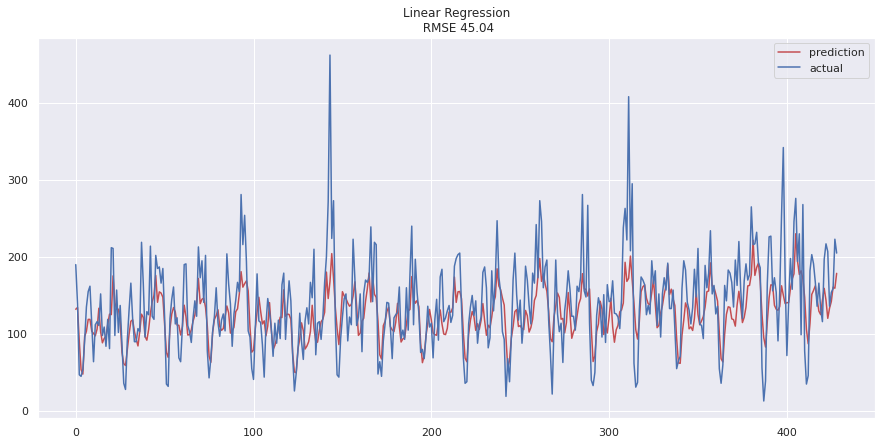

In [71]:
%%time
results_test = []
start_time = time.time()

model = LinearRegression().fit(X_train, y_train)

fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('Linear Regression\n RMSE %.2f' % score)
plt.grid(True);

RMSE: 45.093
CPU times: user 97.5 ms, sys: 111 ms, total: 209 ms
Wall time: 169 ms


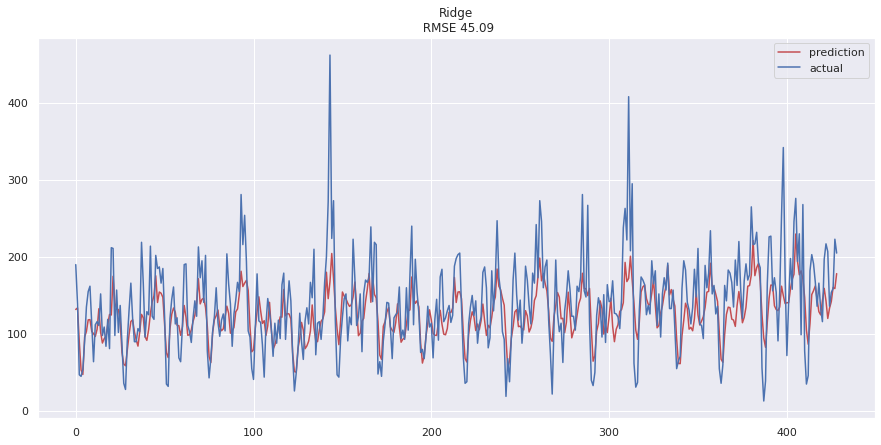

In [72]:
%%time
start_time = time.time()

model = Ridge(alpha=1000, 
              solver='auto', 
              random_state=state).fit(X_train, y_train)

fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('Ridge\n RMSE %.2f' % score)
plt.grid(True);

RMSE: 39.752
CPU times: user 2.1 s, sys: 10.4 ms, total: 2.11 s
Wall time: 2.1 s


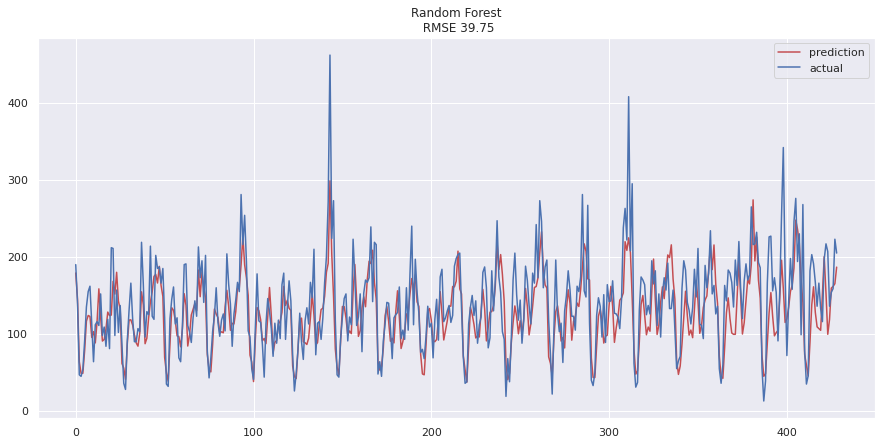

In [73]:
%%time
start_time = time.time()

model = RandomForestRegressor(random_state=state, 
                              max_features=0.6, 
                              n_estimators=90).fit(X_train, y_train)

fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('Random Forest\n RMSE %.2f' % score)
plt.grid(True);

In [74]:
study.best_params

{'subsample': 0.7132317650386633,
 'od_wait': 36,
 'colsample_bylevel': 0.643645171479206,
 'random_strength': 10,
 'l2_leaf_reg': 1.3561656922377945,
 'max_depth': 5,
 'n_estimators': 471,
 'learning_rate': 0.06676449605279625}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 37.2109073	test: 82.2744580	best: 82.2744580 (0)	total: 2.81ms	remaining: 4.91s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 39.29899693
bestIteration = 333

Shrink model to first 334 iterations.
RMSE: 39.299
CPU times: user 868 ms, sys: 84.5 ms, total: 953 ms
Wall time: 2.2 s


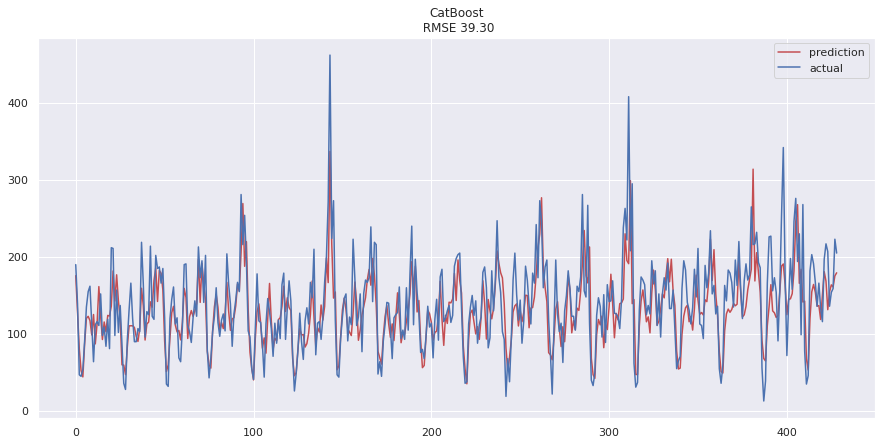

In [76]:
%%time

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

model = CatBoostRegressor(custom_metric=['RMSE'], 
                          subsample=0.7, 
                          od_wait=30, 
                          colsample_bylevel=1.0, 
                          random_strength=2, 
                          l2_leaf_reg=1.0, 
                          max_depth=4, 
                          n_estimators=1747, 
                          learning_rate=0.1)

start_time = time.time()
model.fit(train_pool, eval_set=test_pool, verbose=2000, plot=True)
fit_time = time.time() - start_time
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('CatBoost\n RMSE %.2f' % score)
plt.grid(True);

Тестирование модели XGBoost с числом деревьев 1000 

In [80]:
%%time

import xgboost as xgb

def XGB_forecast(data, lag_start=1, lag_end=13, test_size=0.1, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepare_data(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]['test-rmse-mean']

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test - scale * deviation
    upper = prediction_test + scale * deviation

    Anomalies = np.array([np.NaN] * len(y_test))
    Anomalies[y_test < lower] = y_test[y_test < lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label='prediction')
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title('XGBoost\n RMSE %.2f' % mean_squared_error(y_test, prediction_test, squared=False))
    plt.grid(True)
    plt.legend()

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 31.5 µs


[07:45:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[07:45:21] WARNING: ../src/objective/regression_

ModuleNotFoundError: No module named 'winsound'

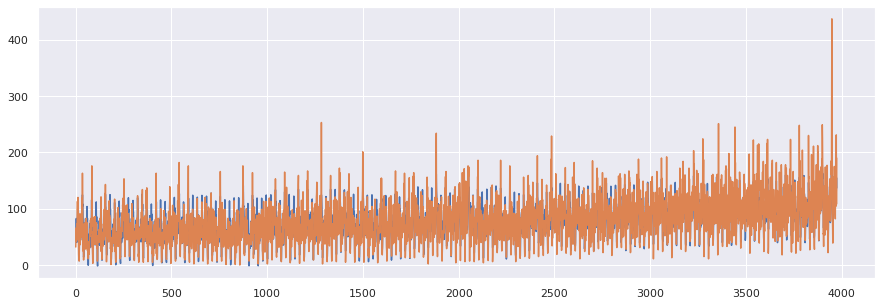

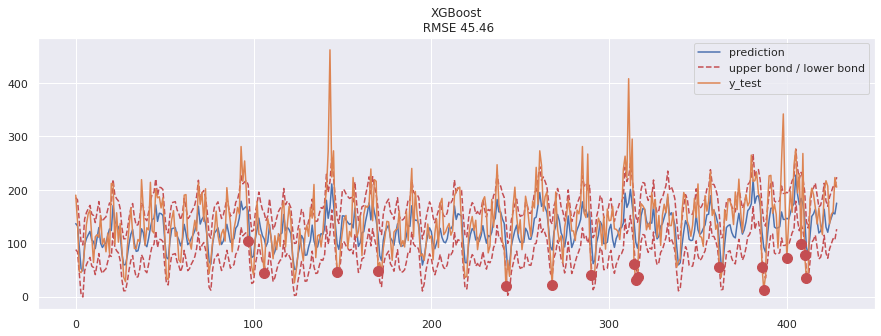

In [81]:
%%time

XGB_forecast(df_taxi)

import winsound
duration = 1000 # миллисекунды
freq = 440 # Гц
winsound.Beep(freq, duration)

Проверка результата на константной модели

RMSE: 85.014
CPU times: user 34.3 ms, sys: 8.26 ms, total: 42.6 ms
Wall time: 36.9 ms


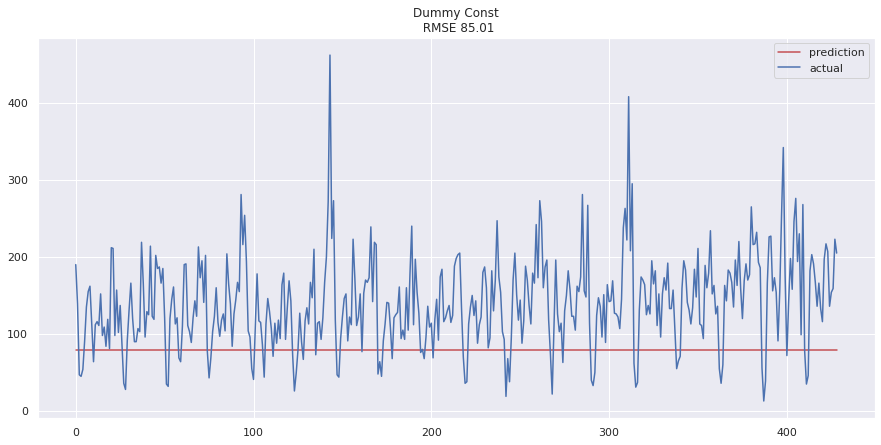

In [79]:
%%time

sns.set()
y_pred = pd.DataFrame(index=range(y_test.shape[0]))
y_pred[0] = y_train.mean()
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': 'Dummy Const', 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('Dummy Const\n RMSE %.2f' % score)
plt.grid(True);

Проверка результата на модели, предсказывающей следующее значение по предыдущему

RMSE: 58.833
CPU times: user 24.2 ms, sys: 332 µs, total: 24.5 ms
Wall time: 21.6 ms


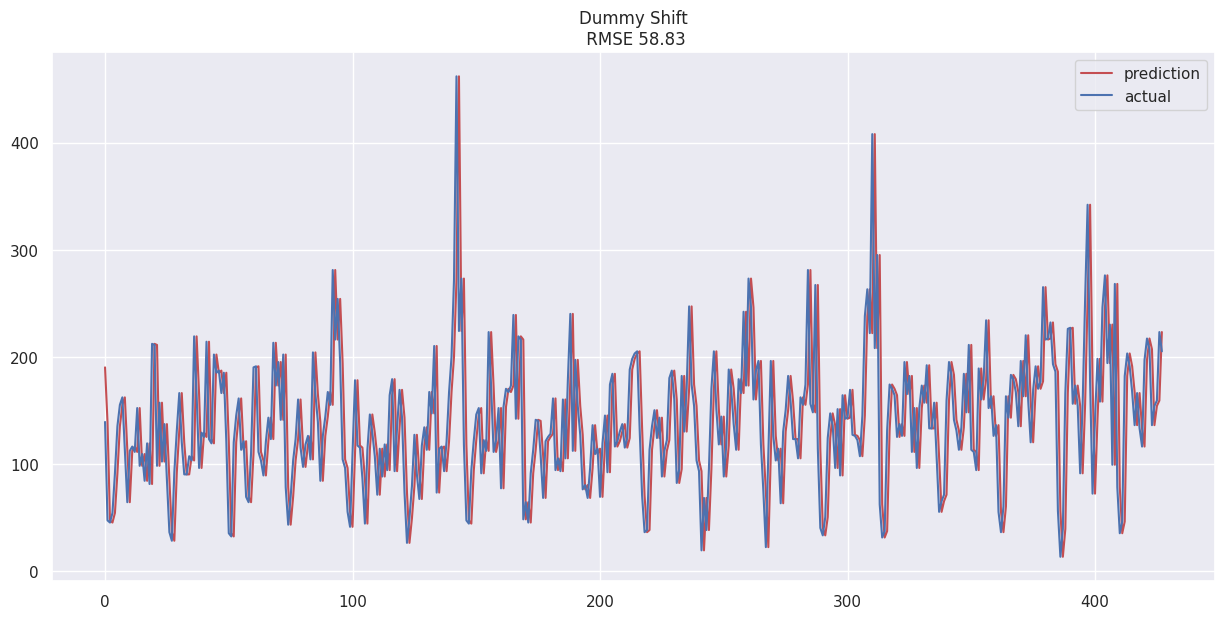

In [42]:
%%time

sns.set()
y_pred_shift = y_test.shift()
y_pred_shift = y_pred_shift[1:].reset_index(drop=True)
y_test_shift = y_test[1:].reset_index(drop=True)
score = mean_squared_error(y_test_shift, y_pred_shift, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': 'Dummy Shift', 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

plt.figure(figsize=(15, 7))
plt.plot(y_pred_shift, 'r', label='prediction')
plt.plot(y_test_shift.values, label='actual')
plt.legend(loc='best')
plt.title('Dummy Shift\n RMSE %.2f' % score)
plt.grid(True);

Подбор числа лагов и размера окна для скользящего среднего для достижения целевого значения RMSE

In [56]:
X_train, X_test, y_train, y_test = prepare_data(df_taxi, lag_start=1, lag_end=13, test_size=0.1, rolling_mean_size=13)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 37.2109073	test: 82.2744580	best: 82.2744580 (0)	total: 1.88ms	remaining: 3.28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 39.29899693
bestIteration = 333

Shrink model to first 334 iterations.
RMSE: 39.299
CPU times: user 707 ms, sys: 38.1 ms, total: 745 ms
Wall time: 2.36 s


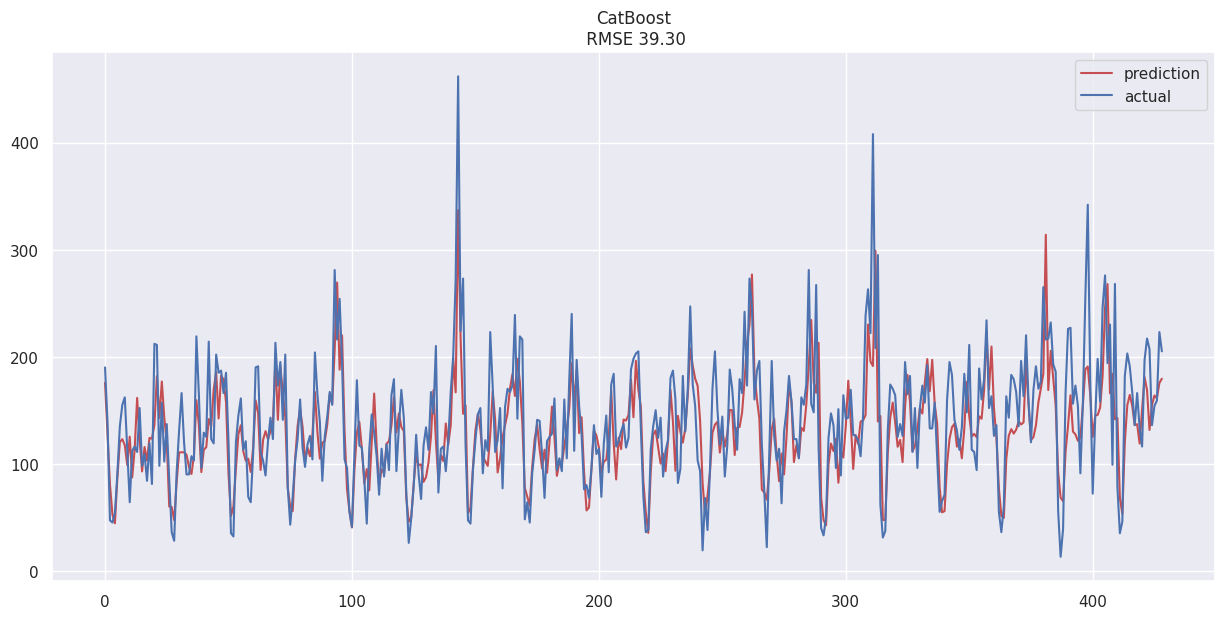

In [57]:
%%time

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

model = CatBoostRegressor(custom_metric=['RMSE'], 
                          subsample=0.7, 
                          od_wait=30, 
                          colsample_bylevel=1.0, 
                          random_strength=2, 
                          l2_leaf_reg=1.0, 
                          max_depth=4, 
                          n_estimators=1747, 
                          learning_rate=0.1)

start_time = time.time()
model.fit(train_pool, eval_set=test_pool, verbose=2000, plot=True)
fit_time = time.time() - start_time
y_pred = model.predict(X_test)
predict_time = time.time() - start_time
score = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: %.3f' % score) 


plt.figure(figsize=(15, 7))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title('CatBoost\n RMSE %.2f' % score)
plt.grid(True);

In [43]:
results_test = pd.DataFrame(results_test)
results_test.loc[results_test['model_name'].isin(['Dummy Shift', 'Dummy Const']), ['fit_time', 'predict_time']] = 0.0
results_test.sort_values('rmse')

,model_name,rmse,fit_time,predict_time
3,CatBoostRegressor,39.3,2.5,2.5
2,RandomForestRegressor,39.8,2.6,0.0
0,LinearRegression,45.0,0.0,0.0
1,Ridge,45.1,0.0,0.0
5,Dummy Shift,58.8,0.0,0.0
4,Dummy Const,85.0,0.0,0.0


#### Выводы

Все подобранные модели демонстрируют одинаково хорошие результаты по качеству и скорости. Возможно их следует сравнить с методами ARIMA(SARIMAX), если потребуется более надежный результат. Целевого значения метрики для тестовой выборки RMSE=48 удалось достичь на модели CatBoost c подбором числа лагов и размера окна скользящего среднего.